In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Load and preprocess the dataset
df = pd.read_csv('Cleaned_MCS_TEAM_DATA.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df = df.sort_values(by='DATETIME')
df.set_index('DATETIME', inplace=True)

# Define features and target
features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
target = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Normalize the numerical features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Time steps and data generator setup
time_steps = 21
data_gen = TimeseriesGenerator(df[features].values, df[target].values, length=time_steps, batch_size=64)

# Build LSTM-GRU hybrid model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(time_steps, len(features))))
model.add(Dropout(0.2))
model.add(GRU(150))
model.add(Dropout(0.2))
model.add(Dense(len(features)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(data_gen, epochs=120)
print(model.summary())

import numpy as np
import pandas as pd

def forecast_weather(model, data, scaler, steps=7):
    # Define your features
    features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
    
    # Check if there is enough data for the model's expected input shape
    required_timesteps = model.input_shape[1]  # Get the number of time steps expected
    if data.shape[0] < required_timesteps:  # If not enough rows
        raise ValueError(f"Not enough data points for the model's expected input shape of {required_timesteps}. Available data points: {data.shape[0]}.")

    # Extract the last known sequence from your data
    last_sequence = data[-required_timesteps:].copy()  # Get last 'n' steps
    last_sequence = last_sequence.values  # Convert to numpy array if it's a DataFrame

    # Ensure last_sequence has the right shape
    last_sequence = last_sequence[np.newaxis, :, :]  # Add batch dimension

    forecast = []
    for _ in range(steps * 3):  # For the next 7 days, 3 times per day (08:00, 12:00, 16:00)
        prediction = model.predict(last_sequence)  # Predict using the last sequence
        forecast.append(prediction[0])  # Append the prediction
        
        # Update the last_sequence for the next prediction
        last_sequence = np.append(last_sequence[:, 1:, :], prediction[np.newaxis, :], axis=1)  # Slide the window

    # Create forecast DataFrame and inverse transform
    forecast_df = pd.DataFrame(forecast, columns=features)
    forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_df), columns=features)

    # Generate forecast dates
    last_date = data.index.max()
    start_date = last_date + pd.Timedelta(days=1)  # Move to the next day
    times = ['08:00', '12:00', '16:00']
    forecast_dates = []

    for i in range(steps):  # For the next 7 days
        for time in times:  # For each time of day
            combined_datetime_str = (start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d') + ' ' + time
            forecast_dates.append(pd.Timestamp(combined_datetime_str))

    # Check if the length of forecast_dates matches the number of rows in forecast_df
    if len(forecast_dates) != len(forecast_df):
        raise ValueError(f"Length of forecast_dates ({len(forecast_dates)}) does not match length of forecast_df ({len(forecast_df)}).")

    # Add dates to the DataFrame for context
    forecast_df['DATETIME'] = forecast_dates

    return forecast_df

# Usage example:
# Assuming `model` is your trained LSTM-GRU model and `df` is your DataFrame containing the original data
forecast_results = forecast_weather(model, df, scaler)
print(forecast_results)

# Save the forecast to a CSV file
forecast_results.to_csv('LSTM_GRU_forecast_results.csv', index=True)




Epoch 1/120


2024-11-04 10:56:20.127075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 10:56:20.127679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 10:56:20.128168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 [==============================] - 3s 34ms/step - loss: 0.0699
Epoch 2/120
29/29 [==============================] - 1s 35ms/step - loss: 0.0378
Epoch 3/120
29/29 [==============================] - 1s 37ms/step - loss: 0.0367
Epoch 4/120
29/29 [==============================] - 1s 38ms/step - loss: 0.0368
Epoch 5/120
29/29 [==============================] - 1s 38ms/step - loss: 0.0361
Epoch 6/120
29/29 [==============================] - 1s 39ms/step - loss: 0.0346
Epoch 7/120
29/29 [==============================] - 1s 39ms/step - loss: 0.0342
Epoch 8/120
29/29 [==============================] - 1s 39ms/step - loss: 0.0340
Epoch 9/120
29/29 [==============================] - 1s 39ms/step - loss: 0.0341
Epoch 10/120
29/29 [==============================] - 1s 39ms/step - loss: 0.0338
Epoch 11/120
29/29 [==============================] - 1s 40ms/step - loss: 0.0333
Epoch 12/120
29/29 [==============================] - 1s 38ms/step - loss: 0.0335
Epoch 13/120
29/29 [=================

2024-11-04 10:58:40.542898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 10:58:40.543404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 10:58:40.543952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 9ms/step
    TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  OCCURENCE OF FLOOD  \
0          29.526649       2.584481          2.548241            0.958389   
1          35.391529      -0.598283          3.855054            0.950878   
2          28.157057       1.235836          1.690646            0.913162   
3          28.464787       4.207233          2.509899            0.896045   
4          34.783855       0.948600          3.568223            0.928569   
5          28.046644       1.903946          1.685366            0.898196   
6          28.700296       4.280257          2.482671            0.904487   
7          35.387959       0.512978          3.668539            0.945370   
8          28.557533       1.328518          1.733403            0.921168   
9          29.505859       3.963242          2.723686            0.915420   
10         35.796955       0.428174          3.855024            0.956145   
11         30.046825     

Actual Data Columns: Index(['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD'],
      dtype='object')


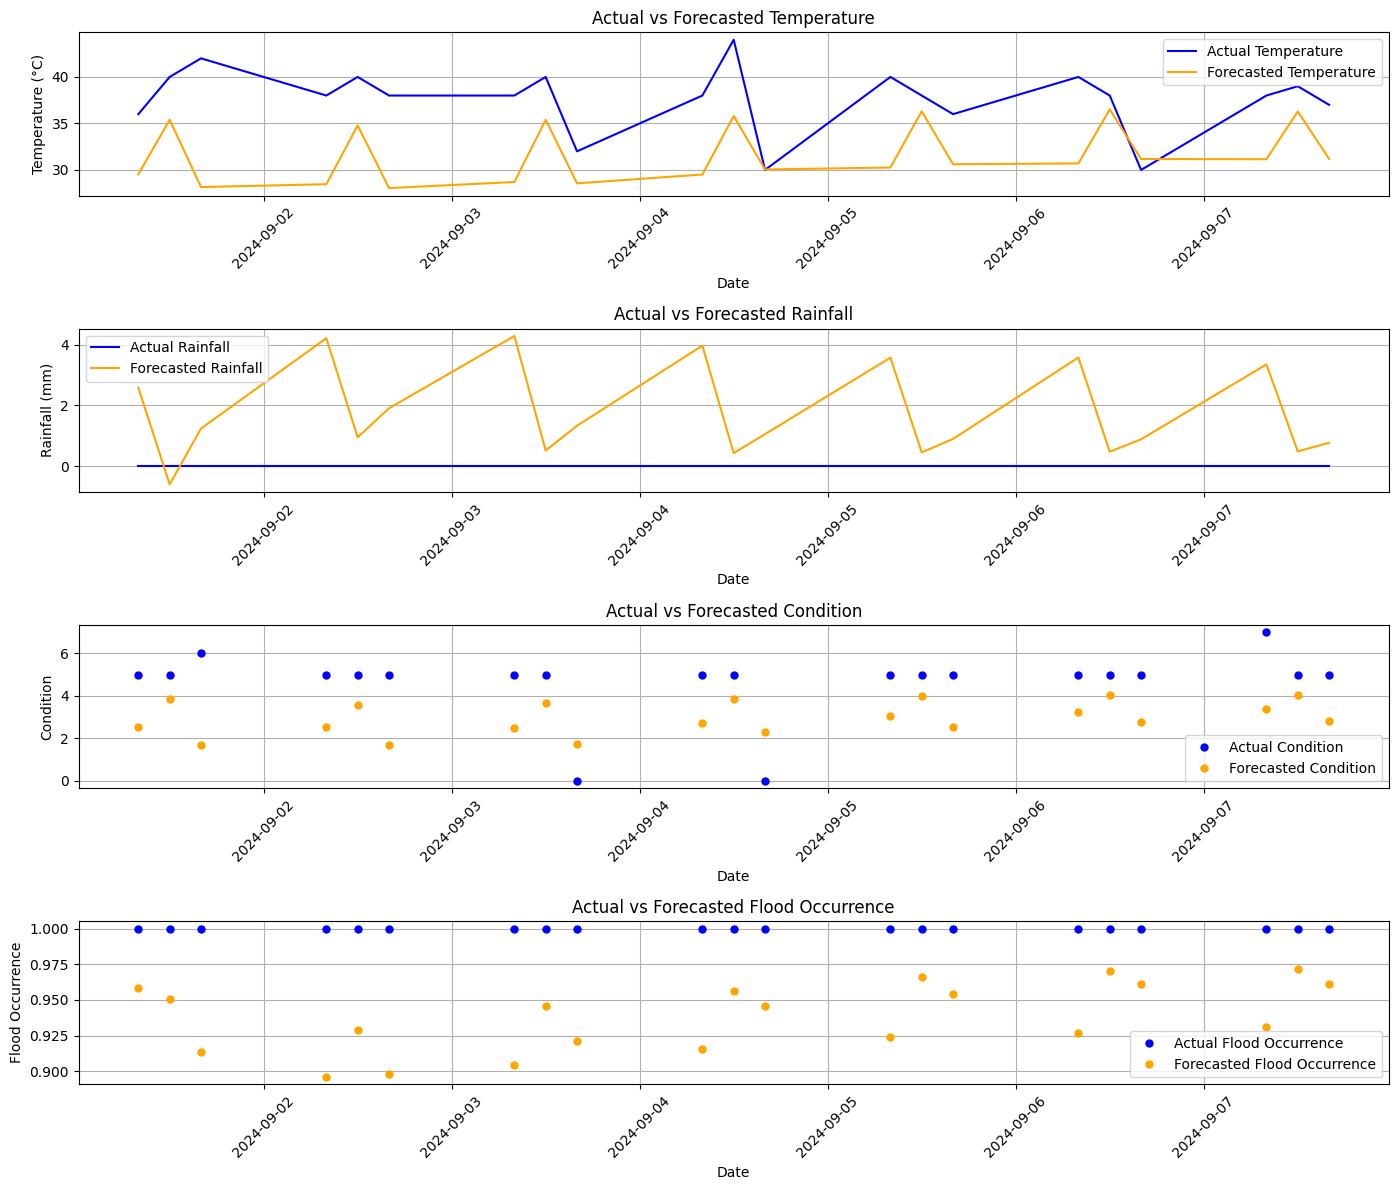

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Check the columns of the actual data
print("Actual Data Columns:", actual_data.columns)

# Assuming forecast_df is already defined and contains the forecasted data
# For demonstration purposes, you may need to define it or load it from another source
# Example structure of forecast_df for context (replace this with actual loading code):
# forecast_df = pd.read_csv('Forecasted_Data.csv')  # Load your forecast data here
# print("Forecast Data Columns:", forecast_df.columns)

# Check the columns of the forecasted data
# print("Forecast Data Columns:", forecast_df.columns)

# Convert 'DATETIME' columns to datetime objects for proper plotting
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Ensure forecast_df is defined and structured correctly
# Assuming forecast_df is defined with a proper structure
# forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Check if DATETIME column exists in forecast_df
if 'DATETIME' not in forecast_results.columns:
    print("Error: 'DATETIME' column not found in forecast_df")
else:
    forecast_results['DATETIME'] = pd.to_datetime(forecast_results['DATETIME'])

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
forecast_results.set_index('DATETIME', inplace=True)

# Create a figure with four subplots for each feature
plt.figure(figsize=(14, 12))

# Subplot 1: Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data.index, actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_results.index, forecast_results['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Actual vs Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 2: Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data.index, actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_results.index, forecast_results['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Actual vs Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 3: Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data.index, actual_data['ACTUAL CONDITION'], label='Actual Condition', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_results.index, forecast_results['ACTUAL CONDITION'], label='Forecasted Condition', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Condition')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 4: Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data.index, actual_data['OCCURENCE OF FLOOD'], label='Actual Flood Occurrence', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_results.index, forecast_results['OCCURENCE OF FLOOD'], label='Forecasted Flood Occurrence', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Flood Occurrence')
plt.xlabel('Date')
plt.ylabel('Flood Occurrence')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

                     TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  \
DATETIME                                                                 
2024-09-01 08:00:00         29.526649       2.584481          2.548241   
2024-09-01 12:00:00         35.391529      -0.598283          3.855054   
2024-09-01 16:00:00         28.157057       1.235836          1.690646   
2024-09-02 08:00:00         28.464787       4.207233          2.509899   
2024-09-02 12:00:00         34.783855       0.948600          3.568223   
2024-09-02 16:00:00         28.046644       1.903946          1.685366   
2024-09-03 08:00:00         28.700296       4.280257          2.482671   
2024-09-03 12:00:00         35.387959       0.512978          3.668539   
2024-09-03 16:00:00         28.557533       1.328518          1.733403   
2024-09-04 08:00:00         29.505859       3.963242          2.723686   
2024-09-04 12:00:00         35.796955       0.428174          3.855024   
2024-09-04 16:00:00         30.046825 

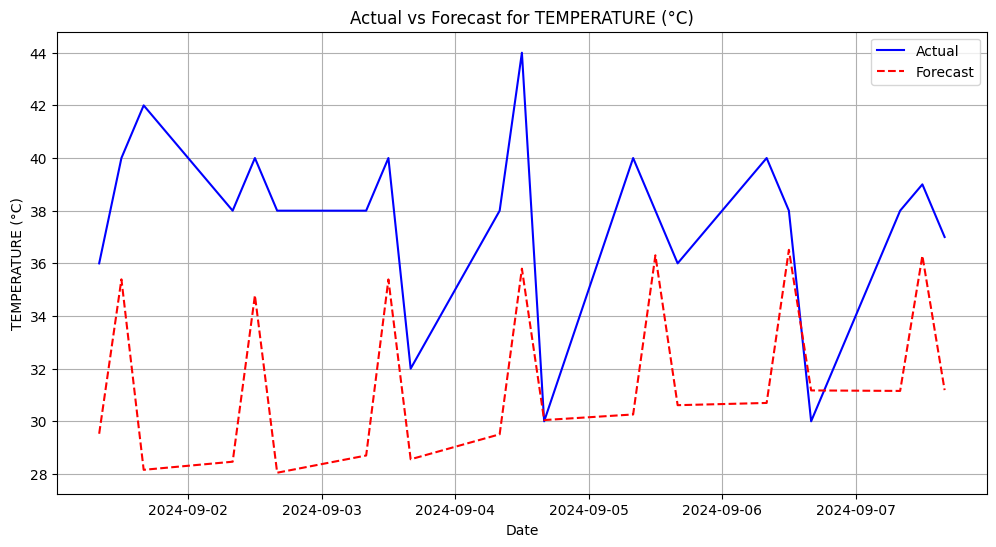

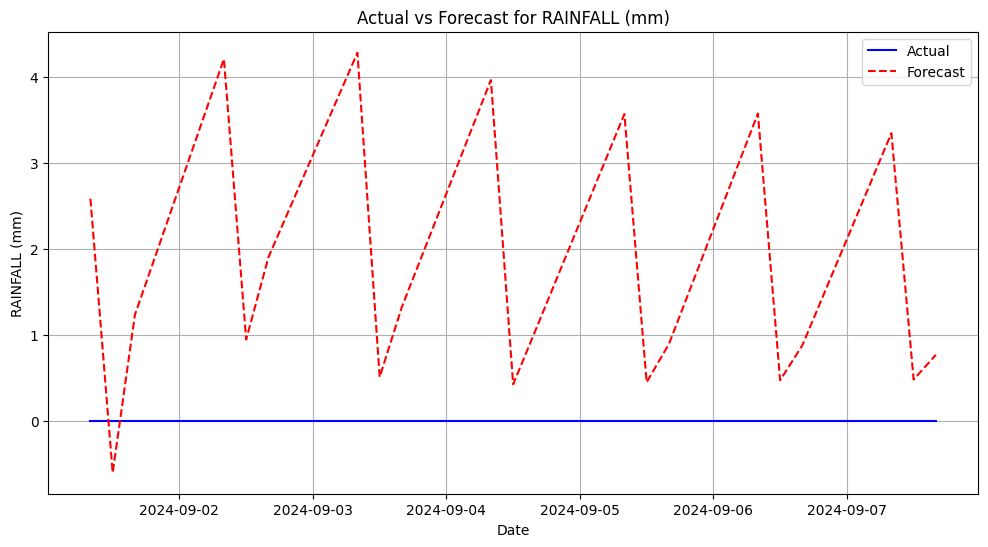

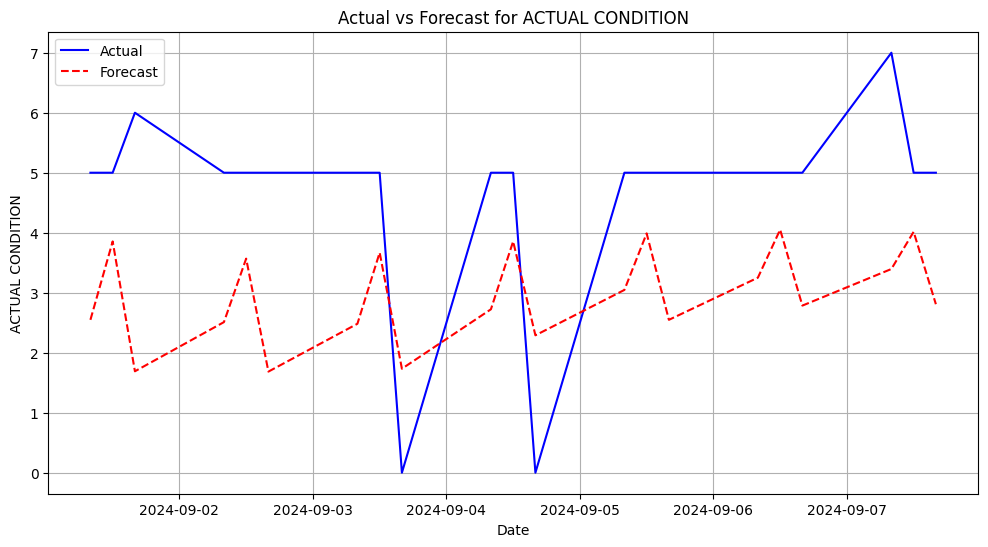

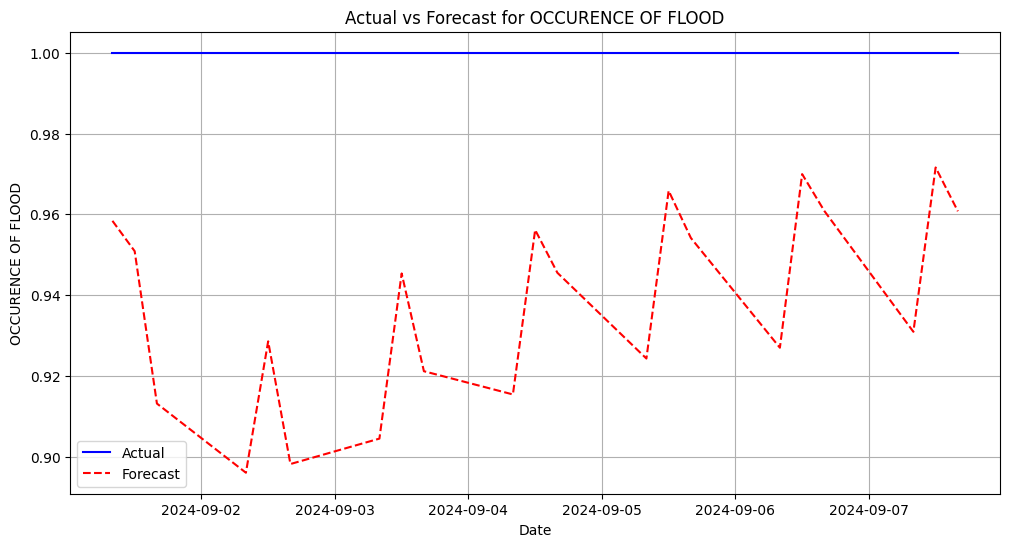

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Convert 'DATETIME' columns to datetime objects for proper plotting and indexing
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])
forecast_results.index = pd.to_datetime(forecast_results.index)
print(forecast_results)

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
#forecast_df.set_index('DATETIME', inplace=True)

# Ensure that the indices align for comparison
common_index = actual_data.index.intersection(forecast_results.index)
actual_data = actual_data.loc[common_index]
forecast_results = forecast_results.loc[common_index]

# Check if the data is aligned properly
if actual_data.empty or forecast_results.empty:
    print("Error: No common indices found between actual and forecast data.")
else:
    # Calculate performance metrics
    metrics = {}
    for column in actual_data.columns:
        if column in forecast_results.columns:
            y_true = actual_data[column]
            y_pred = forecast_results[column]
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            metrics[column] = {'MAE': mae, 'RMSE': rmse}
            print(f"{column} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot actual vs forecasted values for visual comparison
    for column in actual_data.columns:
        if column in forecast_results.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(actual_data.index, actual_data[column], label='Actual', color='blue')
            plt.plot(forecast_results.index, forecast_results[column], label='Forecast', color='red', linestyle='--')
            plt.title(f'Actual vs Forecast for {column}')
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.legend()
            plt.grid(True)
            plt.show()

Performance Report: Hybrid LSTM-GRU Model
Engr. Jamie Eduardo Rosal, MSCpE

LSTM-GRU Model Performance Report
Introduction
This report outlines the performance metrics of an LSTM-GRU model designed for forecasting weather data, specifically focusing on four key outputs: Temperature (°C), Rainfall (mm), Actual Condition, and Occurrence of Flood. The performance is evaluated using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) metrics, which provide insight into the accuracy and reliability of the model's predictions.

Performance Metrics
Feature	Mean Absolute Error (MAE)	Root Mean Squared Error (RMSE)
Temperature (°C)	6.09	7.02
Rainfall (mm)	    1.79	2.26
Actual Condition	2.07	2.25
Occurrence of Flood	0.06	0.07
Analysis
Temperature (°C):

The MAE of 6.09 indicates that, on average, the model's temperature predictions deviate by approximately 6.09°C from the actual values.
The RMSE of 7.02 highlights that the errors are more pronounced with larger deviations, reflecting the model's challenges in accurately predicting extreme temperatures.
Rainfall (mm):

The MAE for rainfall predictions is 1.79 mm, suggesting a relatively low average error, which is beneficial for applications requiring precise precipitation forecasts.
The RMSE of 2.26 indicates that while the model performs well on average, there may still be occasional larger prediction errors.
Actual Condition:

The MAE of 2.07 suggests that the model occasionally misclassifies the actual weather conditions, but the error margin is manageable.
The RMSE of 2.25 reflects similar performance to the MAE, indicating that the predictions are generally reliable but can occasionally be inaccurate.
Occurrence of Flood:

The MAE of 0.06 indicates excellent performance in predicting the occurrence of floods, with the model rarely misclassifying flood events.
The RMSE of 0.07 reinforces this finding, showing that the model effectively identifies when flooding is likely to occur.
Model Summary
The model architecture used for forecasting is a sequential LSTM-GRU network, comprising the following layers:

LSTM Layer 1: 150 units, 93,000 parameters.
Dropout Layer: Prevents overfitting, applied after the first LSTM layer.
LSTM Layer 2: 150 units, 180,600 parameters.
Dropout Layer: Applied after the second LSTM layer.
Dense Layer: Outputs four predictions corresponding to the features, with 604 parameters.
Total Model Parameters
Total Parameters: 274,204
Trainable Parameters: 274,204
Non-Trainable Parameters: 0


                                           Conclusion
The LSTM-GRU model exhibits promising results in forecasting key weather parameters, with particular strength in predicting rainfall and flood occurrence. While the model's performance is satisfactory, especially for applications requiring flood predictions, further optimization may enhance accuracy for temperature forecasts. Continuous refinement of the model architecture and training data could lead to improved predictive capabilities.
